## Using The Super Resolution Convolutional Neural Network for Image Restoration

The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, **enhance!** 

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras.  This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014.  You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images.  As a result, we can use it to improve the image quality of low resolution images.  To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.  

Furthermore, we will be using OpenCV, the Open Source Computer Vision Library.  OpenCV was originally developed by Intel and is used for many real-time computer vision applications.  In this particular project, we will be using it to pre and post process our images.  As you will see later, we will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces.  This is necessary because the SRCNN network was trained on the luminance (Y) channel in the YCrCb color space.  

We took the reference from the git-hub link - https://github.com/xoraus/Super-Resolution-CNN-for-Image-Restoration/blob/master/Image%20Super%20Resolution%20with%20the%20SRCNN%20(Jupyter%20Notebook).ipynb


### 1. Importing Packages

In [1]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
import tensorflow as tf

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Keras: 2.9.0
OpenCV: 4.6.0
NumPy: 1.21.5
Matplotlib: 3.5.1
Scikit-Image: 0.19.2


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import warnings
warnings.filterwarnings('ignore')
# python magic function, displays pyplot figures in the notebook
%matplotlib inline

### 2. Image Quality Metrics   

In [3]:
# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

### 3. Preparing Images

In [4]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    # loop through the files in the directory
    for file in os.listdir(path):
        if file == ".ipynb_checkpoints":
            continue
        if file == "Degraded_images":
            continue
        if file == "Hough_image":
            continue   
            
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h // factor)
        new_width = int(w // factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        print('Saving {}'.format(file))
        cv2.imwrite('images/Degraded_images/{}'.format(file), img)
        
        #hough transform
        
    path2 = "images/Hough_image"
    
    for file in os.listdir(path2):
        if file == ".ipynb_checkpoints":
            continue
        if file == "Degraded_images":
            continue
        if file == "Hough_image":
            continue  
            
        # open the file
        img2 = cv2.imread(path2 + '/' + file)
        
        # resize the image - up
        img2 = cv2.resize(img2, (256, 256), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img2)

In [5]:
prepare_images('source/', 2)

Saving download.jpg
Saving Image_256.jpg
Saving Image_256_trail.png
Saving download.jpg


### 3. Testing Low Resolution Images

In [6]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    # open target and reference images
    #print(file)
    if file == ".ipynb_checkpoints":
        continue
    if file == "Degraded_images":
        continue
    if file == "Hough_image":
        continue
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    #print(ref)
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

download.jpg
PSNR: 24.775909036394165
MSE: 216.51573181152344
SSIM: 0.6723400843677266

Image_256.jpg
PSNR: 24.775909036394165
MSE: 216.51573181152344
SSIM: 0.6723400843677266

Image_256_trail.png
PSNR: 19.743088010989695
MSE: 689.8768310546875
SSIM: 0.6232461961889157



### 4. Building the SRCNN Model

In [7]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

### 5. Deploying the SRCNN
Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN.  These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

In [8]:
# define necessary image processing functions
def modcrop(img, scale):
    height, width = img.shape[:2]
    new_height = height - height % scale
    new_width = width - width % scale
    return img[:new_height, :new_width]


In [9]:
def predict(image_path):
    # load the SRCNN model
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the images with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (SRCNN trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with SRCNN
    pre = srcnn.predict(Y)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    border = 6
    temp = temp[border: -border, border: -border]
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraded image
#     ref = shave(ref.astype(np.uint8), 6)
    
    
    ref = ref[border: -border, border: -border]

    degraded = degraded[border: -border, border: -border]
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

1/1 [==============================] - 0s 409ms/step
Degraded Image: 
PSNR: 24.50020087684902
MSE: 230.7067350844214
SSIM: 0.6669460146704366

Reconstructed Image: 
PSNR: 25.108079300021508
MSE: 200.57298176091044
SSIM: 0.6909052596994777



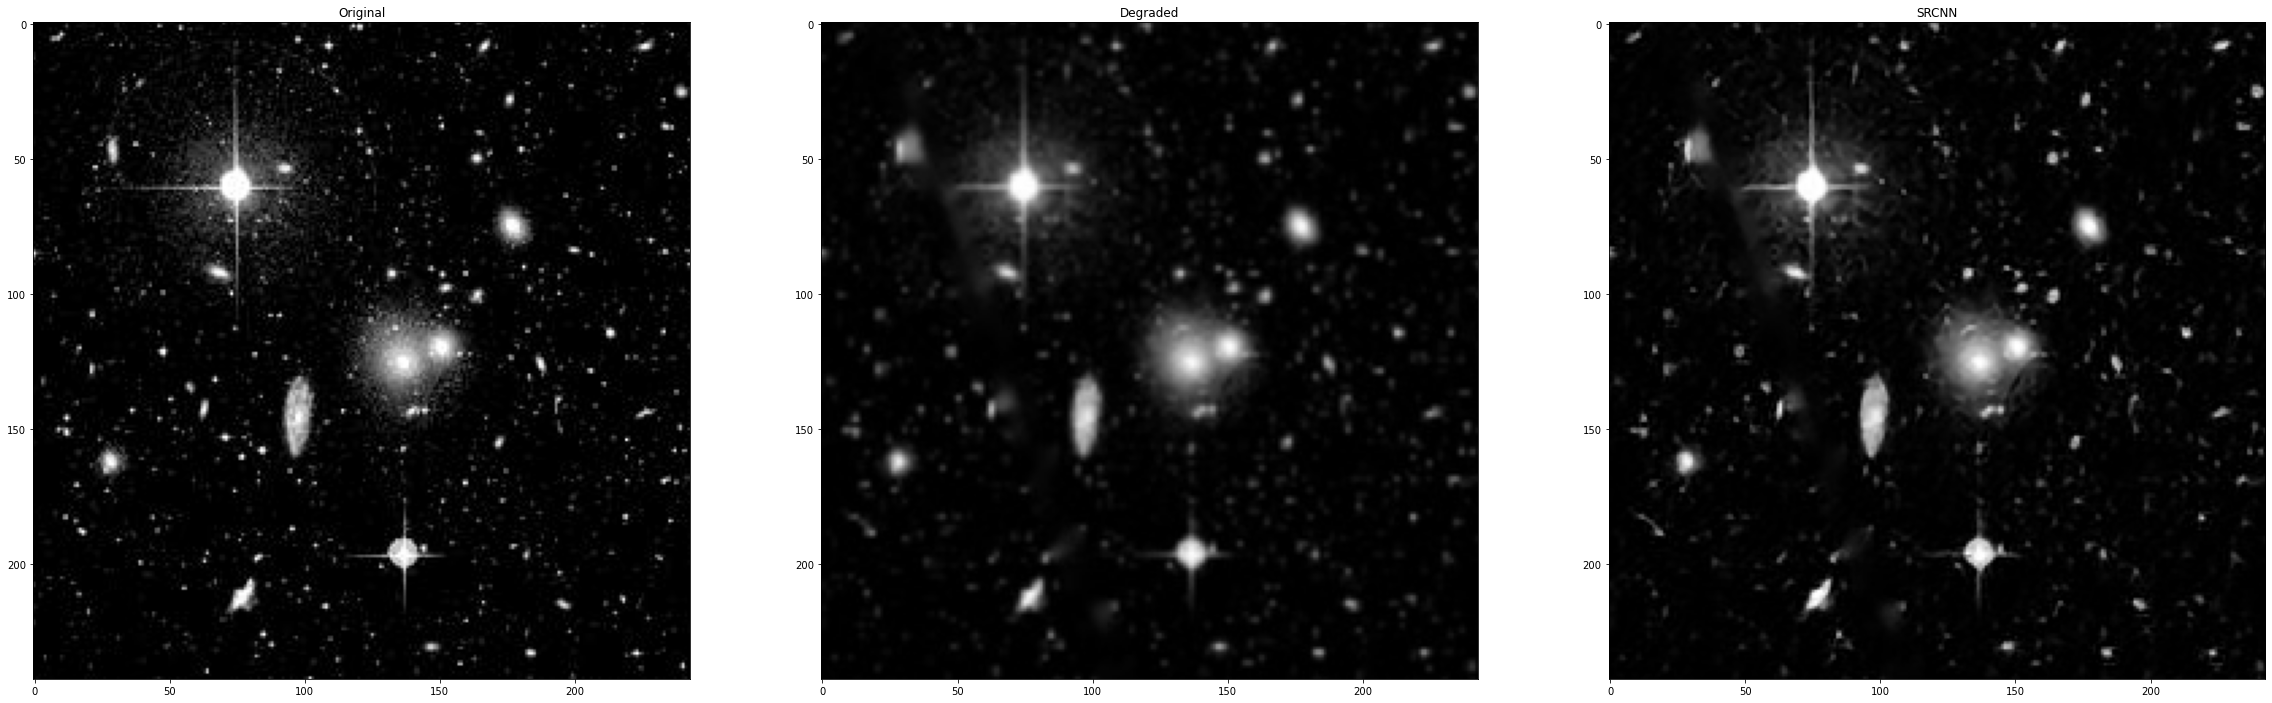

In [10]:
ref, degraded, output, scores = predict('images/download.jpg')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1],scores[1][2]))
cv2.imwrite('output/{}'.format(file), output)


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(40, 16))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

plt.show()